# Assignment 2: XAI
Task: Predict the diagnosis for given x-ray images
- Task Information: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/
- Data Information: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data
<br>

Report
- Task definition
- Data description (results of data exploration)
- Description of baseline method
- Desciption of hyperparameter optimization
- Results: A table for...
    - Baseline results (repication of exisiting method)
    - Results of hyperparameter optimization/alternative approach
    - Extensive analysis of best model using XAI techniques
- Brief conclusion: Which feature respresentation/model worked the best and why

## Code

In [17]:
# # Dataset installation
# import kagglehub

# install_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# print("Path to dataset files:", install_path)

In [18]:
# Import packages
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

### 1.0 Dataset Exploration
- Download dataset from Kaggle
- Explore dataset to under input features (images), classes (normal vs. pneumonia), and distribution of data
- Visualize sample images for both clases, along with their labels
    - Can use https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy as reference (do not just copy)

In [19]:
# Get dataset directories 
main_dir = 'chest-x-ray'

test_dir = os.path.join(main_dir, 'test')

train_dir = os.path.join(main_dir, 'train')

# Set labels
labels=['NORMAL', 'PNEUMONIA']

# Set preferred image size for reshaping later
img_size = 150

# Function for data
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
            data.append([resized_arr, class_num])
    return data

# Load dataset
train = get_data(train_dir)
test = get_data(test_dir)

/opt/anaconda3/envs/testname/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: ylabel='count'>

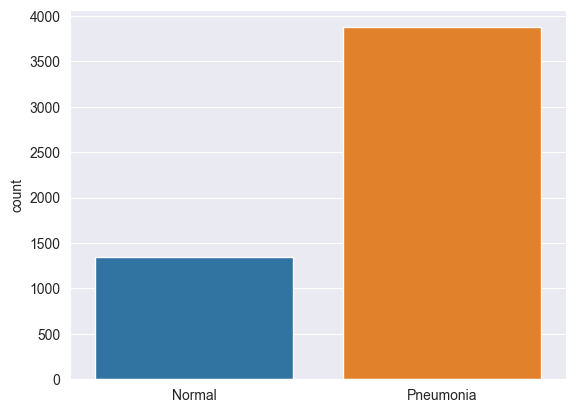

In [20]:
# Map labels to strings
l = []
for i in train:
    if i[1] == 1:
        l.append("Pneumonia")
    else:
        l.append("Normal")

sns.set_style('darkgrid')
sns.countplot(x=l)


Text(0.5, 1.0, 'PNEUMONIA')

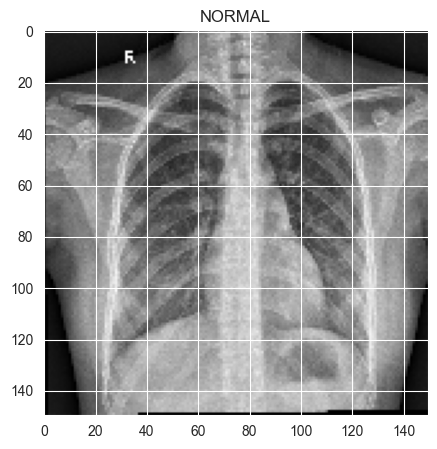

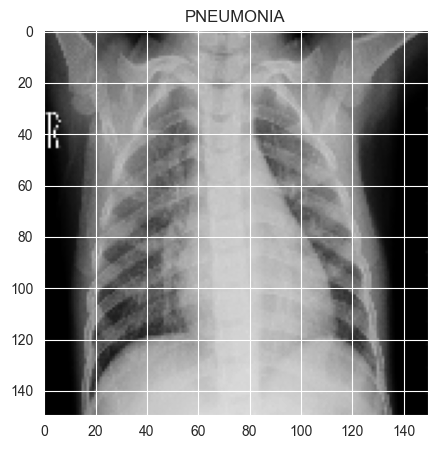

In [21]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [22]:
# Seperate features and labels
x_train = []
y_train = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

In [23]:
# Normalize the data
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

Data Augmentation:
- Mirroring/flipping
- Tilting
- Contrast/hue/saturation
- Cropping/size
Makes classifier more robust and increases dataset size 

In [24]:
# Increase data set size with data augmentation to 
#   prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

### 2.0 CNN Baseline
- Use example CNN architecture provide in Kaggle code as a base. Understand role of key components like convolutional layers, pooling layers, and fully connected layers
- Train model on training dataset
- Track and report model performance metrics (accuracy, loss) during training and on the test dataset

In [28]:
model = Sequential()

# LAYER 1
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# LAYER 2
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# LAYER 3
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# LAYER 4
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# LAYER 5
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

print("Loss: " , model.evaluate(x_test,y_test)[0])
print("Accuracy; " , model.evaluate(x_test,y_test)[1]*100 , "%")






Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_15 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_11 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_16 (Bat  (None, 75, 75, 64)      

In [13]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()



NameError: name 'model' is not defined

### 3.0 Performance Evaluation
- After training, evaluate model on test set
- Present the confusion matrix, precision, recall, and F1 score for baseline model


### 4.0 Hyperparameter Optimization & Alternative Models
- Use an HPO method (SMAC3, Bayesian optimization, etc) to try to improve the current model; use a realistic budget (do no run experiments for more than a day)
- Try a different model (machline learning technique) for the given task, provide motivation as to why
- Present confusion matrix, precision, recall, and F1 score on train and test set for the final optimized CNN model and the alternative ML model

In [ ]:
# Hyperparameter optimization
# Bayesian optimization
# Optimize kernel, number of filters, strides, padding
# Define parameter search space
param_space = {
    'kernel': (0,1),
    'filters': (0,1),
    'stride': (0,1),
    'padding': (0,1) 
}

In [ ]:
# Alternate model

### 4.0 Explainable AI
- Inspect misclassification errors and use explainable AI techniques to highlight what the models are focusing on
- Feature importance with Grad-CAM (example at https://keras.io/examples/vision/grad_cam/, https://github.com/ismailuddin/gradcam-tensorflow-2, or https://deel-ai.github.io/xplique/v1.4.0/)
    - Use Grad-CAM (Gradient-weighted Class Activation Mapping) to visualize which parts of the input images contribute most to the model's predictions
    - Choose 5-10 misclassified samples and use Grad-CAM to inspect which regions the model is focusing on
    - Interpret the results:
        - Are the activations reasonable?
        - Can it be identified why the model made incorrect predictions for chosen samples?
    - Layer-wise Relevance Propagation (LRP) (optional for bonus points)
        - Apply LRP to further analyze how different layers of network contribute to the final predictions
        - Compare insights from LRP with Grad-CAM, are there any differences in how each method highlights the important regions of the image?

## Report
- Task definition
- Data description (results of data exploration)
- Description of baseline method
- Desciption of hyperparameter optimization
- Results: A table for...
    - Baseline results (repication of exisiting method)
    - Results of hyperparameter optimization/alternative approach
    - Extensive analysis of best model using XAI techniques
- Brief conclusion: Which feature respresentation/model worked the best and why
<br>
Maximum 8 pages

## Submission
Submit report as pdf along with code zipfile in Brightspace